# Install and import libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!pip install mxnet-cu112
#if you pip installed the plain `mxnet` before, uncomment the following two lines to install the GPU version. You may need to replace `cu92` according to your CUDA version.
#!nvcc --version # get cuda version
#!pip uninstall mxnet

In [ ]:
!pip install higra

In [ ]:
# needed to make mxnet run, installing may take a while
!apt install nvidia-cuda-toolkit --yes

In [7]:
import os
import sys
import glob
import time

import numpy as np
np.bool = np.bool_ # reassigning deprecated np.bool for mxnet
import pandas as pd

import cv2
import higra as hg

from osgeo import gdal
from osgeo import ogr
from osgeo import osr

import matplotlib.pyplot as plt

In [9]:
import mxnet as mx
from mxnet import nd, gpu, gluon, autograd, npx, image
from mxnet.gluon.data import DataLoader
from mxnet.gluon.data.vision import transforms
from mxnet.gluon.loss import Loss

In [ ]:
# set working directory
%cd '/content/drive/MyDrive/pseudo-fields/'

In [44]:
# import DECODE repo
sys.path.insert(0,'decode/')
from decode.FracTAL_ResUNet.nn.loss.mtsk_loss import *
from decode.FracTAL_ResUNet.models.heads.head_cmtsk import *
from decode.FracTAL_ResUNet.models.semanticsegmentation.FracTAL_ResUNet_features import *
from decode.FracTAL_ResUNet.models.semanticsegmentation.FracTAL_ResUNet import FracTAL_ResUNet_cmtsk

# Helpers

In [51]:
############################################
# read & write tifs

# read rgb tif to nd.array on gpu
def open_tif_rgb(pth):
  img = nd.array(gdal.Open(pth).ReadAsArray(), dtype='float32', ctx=gpu(0))
  img = np.flip(img, axis=0) #bgr to rgb
  return img

# create in memory ds
def create_mem_ds(ref_pth, n_bands, dtype=gdal.GDT_Float32):
    drvMemR = gdal.GetDriverByName('MEM')
    ds = gdal.Open(ref_pth)
    mem_ds = drvMemR.Create('', ds.RasterXSize, ds.RasterYSize, n_bands, dtype)
    mem_ds.SetGeoTransform(ds.GetGeoTransform())
    mem_ds.SetProjection(ds.GetProjection())
    return mem_ds

# create copy of memory ds
def copy_mem_ds(pth, mem_ds):
    copy_ds = gdal.GetDriverByName("GTiff").CreateCopy(pth, mem_ds, 0, options=['COMPRESS=LZW'])
    copy_ds = None

In [52]:
############################################
# watershed segmentation
# produces field instances from
# model predictions
def InstSegm(extent, boundary, t_ext=0.4, t_bound=0.2):
    """
    INPUTS:
    extent : extent prediction
    boundary : boundary prediction
    t_ext : threshold for extent
    t_bound : threshold for boundary
    OUTPUT:
    instances
    """

    # threshold extent mask
    ext_binary = np.uint8(extent >= t_ext)

    # strong boundaries for
    # non-field pixels
    input_hws = np.copy(boundary)
    input_hws[ext_binary == 0] = 1

    # directed graph
    size = input_hws.shape[:2]
    graph = hg.get_8_adjacency_graph(size)
    edge_weights = hg.weight_graph(
        graph,
        input_hws,
        hg.WeightFunction.mean
    )

    tree, altitudes = hg.watershed_hierarchy_by_dynamics(
        graph,
        edge_weights
    )

    # get field instances
    # by cutting the graph using altitude
    instances = hg.labelisation_horizontal_cut_from_threshold(
        tree,
        altitudes,
        threshold=t_bound)

    instances[ext_binary == 0] = -1

    return instances

In [53]:
############################################
# functions to create multi-taks labels

# boundary from field extent
def get_boundary(label, kernel_size = (2,2)):
    tlabel = label.astype(np.uint8)
    temp = cv2.Canny(tlabel,0,1)
    tlabel = cv2.dilate(
        temp,
        cv2.getStructuringElement(
            cv2.MORPH_CROSS,
            kernel_size),
        iterations = 1)
    tlabel = tlabel.astype(np.float32)
    tlabel /= 255.
    return tlabel

# within-field distance to boundary
def get_distance(label):
    tlabel = label.astype(np.uint8)
    dist = cv2.distanceTransform(tlabel, cv2.DIST_L2, 0)

    # get unique objects
    output = cv2.connectedComponentsWithStats(label, 4, cv2.CV_32S)
    num_objects = output[0]
    labels = output[1]

    # min/max normalize dist for each object
    for l in range(num_objects):
        dist[labels==l] = (dist[labels==l]) / (dist[labels==l].max())

    return dist

# crop field extent
def get_crop(image, kernel_size = (2,2)):

    im_floodfill = image.copy()
    h, w = image.shape[:2]
    mask = np.zeros((h+2, w+2), np.uint8)

    # floodfill
    cv2.floodFill(im_floodfill, mask, (0,0), 1);

    # invert
    im_floodfill = cv2.bitwise_not(im_floodfill)

    # kernel size
    kernel = np.ones(kernel_size, np.uint8)

    # erode & dilate
    img_erosion = cv2.erode(im_floodfill, kernel, iterations=1)
    return cv2.dilate(img_erosion, kernel, iterations=1) - 254


# Load model

In [ ]:
# path to pre-trained model
model = 'model/india_airbus_spot_model.params'

# model hyperparams
depth=6
NClasses=1
nfilters_init=32
linear_norm = False
#norm = 'none'

# load params
net = FracTAL_ResUNet_cmtsk(nfilters_init=nfilters_init, NClasses=NClasses,depth=depth)
net.load_parameters(model)
net.collect_params().reset_ctx(gpu(0))


# Pseudo label selection parameters



In [55]:
############################################
# pseudo-label selection thresholds

############
# fields

# percentile instance-level semantic uncertainty (SemC)
apply_p_scor = True
p_scor = 99

# percentile instance-level instance uncertainty (InsC)
apply_p_inst = False
p_inst = 75

# absolute instance-level semantic uncertainty (SemC)
apply_a_scor = False
a_scor = 0.90

# size threshold (pixels)
t_size = 500
apply_t_size = False

############
# non-crop

# percentile instance-level semantic uncertainty (SemC)
apply_p_ncrp = True
p_ncrp = 10

# percentile instance-level instance uncertainty (InsC)
apply_p_inlw = False
p_inlw = 25

# absolute instance-level semantic uncertainty (SemC)
apply_a_ncrp = False
a_ncrp = 0.75

In [56]:
############################################
# instance generation thresholds
# define probability threshold of field extent and boundary
# for hierarchical watershed segmentation (see Waldner et al. 2021)
t_ext=0.4
t_bound=0.2


In [ ]:
############################################
# define folder containing input images
# search input files based on extension
img_path = 'sample_data/'
in_files = sorted(glob.glob(img_path + '*.tif'))
print(in_files)

# write pseudo labels as *.tif to output folder
write=True
if write:
  # create output folder
  out_path = 'pseudo_labels/'
  os.makedirs(out_path, exist_ok=True)

# create plots?
plot=True

# Run label selection

sample_data/82002.tif
field instances: 458


<ipython-input-70-0e4277396085>:35: RuntimeWarning: All-NaN slice encountered
  instance_uncert = np.array([np.nanmedian(bounds[(inst==id)]) for id in iids])


pseudo labels generated: 6


<ipython-input-53-60dce5d361cb>:30: RuntimeWarning: divide by zero encountered in divide
  dist[labels==l] = (dist[labels==l]) / (dist[labels==l].max())
<ipython-input-53-60dce5d361cb>:30: RuntimeWarning: invalid value encountered in divide
  dist[labels==l] = (dist[labels==l]) / (dist[labels==l].max())


pseudo_labels//82002_mtsk.tif


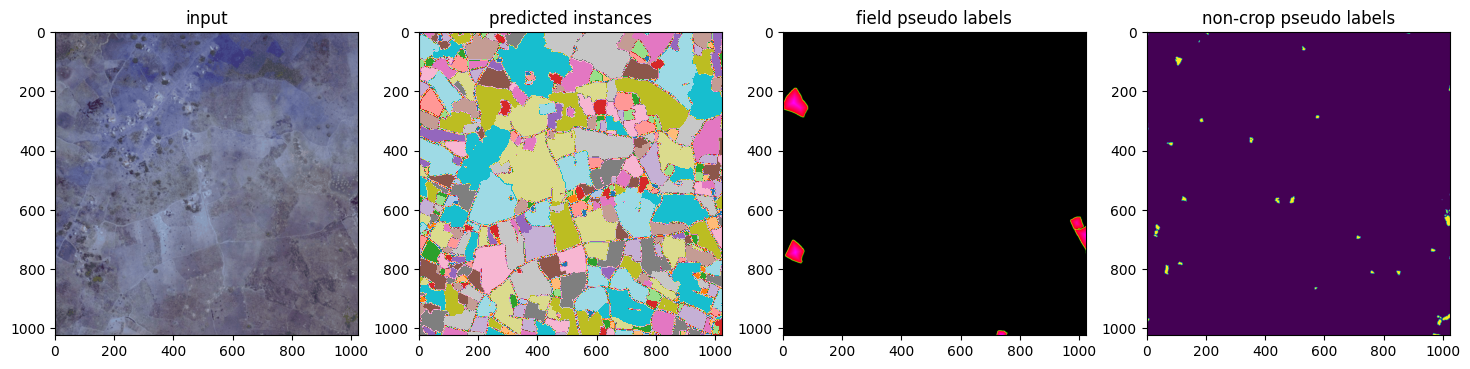

8.706950664520264
sample_data/82006.tif
field instances: 316
pseudo labels generated: 5
pseudo_labels//82006_mtsk.tif


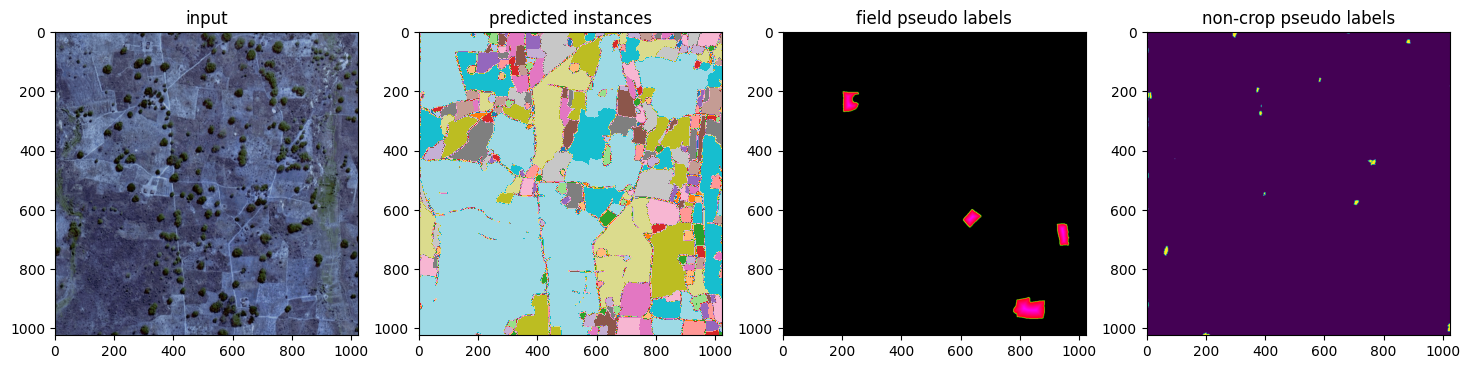

6.428370237350464
sample_data/82010.tif
field instances: 420
pseudo labels generated: 6
pseudo_labels//82010_mtsk.tif


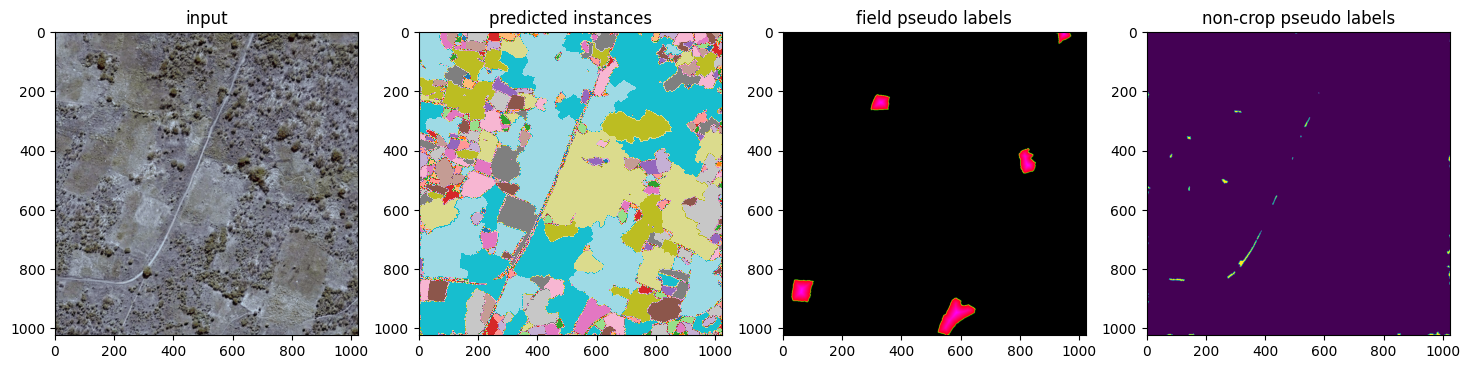

7.946206569671631
sample_data/82012.tif
field instances: 377
pseudo labels generated: 5
pseudo_labels//82012_mtsk.tif


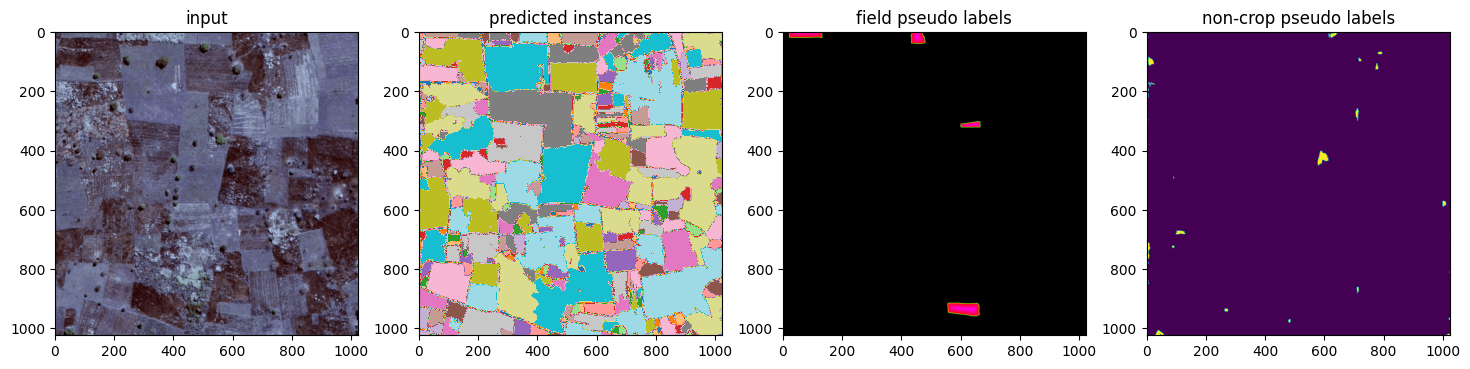

6.771518707275391


In [70]:
for iter, in_file in enumerate(in_files):

  tic = time.time()
  ###################################################################
  # open & predict
  print(in_file)

  input = open_tif_rgb(in_file)
  in_tns = input[None,:,:,:]

  preds = net(in_tns)

  ###################################################################
  # create instances
  example_extent = np.squeeze(preds[0]).asnumpy()
  example_boundary = np.squeeze(preds[1]).asnumpy()
  inst = InstSegm(example_extent, example_boundary, t_ext=t_ext, t_bound=t_bound)

  ###################################################################
  # copy array
  inst_full = np.copy(inst)
  inst_ncrp = np.copy(inst)

  ###################################################################
  # get unique ids
  iids = np.unique(inst)
  iids = iids[(iids!=0)]
  print('field instances: '+ str(len(iids)))

  ###################################################################
  # instance level scores
  instance_score = np.array([np.nanmedian(example_extent[(inst==iid)]) for iid in iids])
  bounds = example_boundary*get_boundary(inst, kernel_size=(1,1))
  bounds[bounds==0] = np.nan
  instance_uncert = np.array([np.nanmedian(bounds[(inst==id)]) for id in iids])
  instance_size = np.array([len(inst[(inst==id)]) for id in iids])

  ###################################################################
  # pseudo label selection

  ###################################################################
  # select field instances based on semantic and instance uncertainty
  fids = []
  if apply_p_scor:
    t_scor = np.nanpercentile(instance_score, p_scor) #percentile instance-level semantic uncertainty
    rmv = np.array([iid for i, iid in enumerate(iids) if (instance_score[i] < t_scor)])
    fids = np.append(fids, rmv, axis=0)

  if apply_p_inst:
    t_inst = np.nanpercentile(instance_uncert, p_inst) #percentile instance-level instance uncertainty
    rmv = np.array([iid for i, iid in enumerate(iids) if (instance_score[i] < t_inst)])
    fids = np.append(fids, rmv, axis=0)

  if apply_a_scor:
    rmv = np.array([iid for i, iid in enumerate(iids) if (instance_score[i] < a_scor)])

  ###################################################################
  # select non cropland instances based on semantic and instance uncertainty
  cids = []
  if apply_p_ncrp:
    t_ncrp = np.nanpercentile(instance_score, p_ncrp) #percentile instance-level semantic uncertainty for non-crop instances
    rmv = np.array([iid for i, iid in enumerate(iids) if (instance_score[i] > t_ncrp)])
    cids = np.append(cids, rmv, axis=0)

  if apply_p_inlw:
    t_inlw = np.nanpercentile(instance_uncert, p_inlw) #percentile instance-level instance uncertainty for non-crop instances
    rmv = np.array([iid for i, iid in enumerate(iids) if (instance_uncert[i] > t_inlw)])

  if apply_a_ncrp:
    rmv = np.array([iid for i, iid in enumerate(iids) if (instance_score[i] > a_ncrp)])

  ###################################################################
  # set non-matching instances to
  for fid in fids:
    inst[(inst==fid)] = 0

  for cid in cids:
    inst_ncrp[(inst_ncrp==cid)] = 0
  inst_ncrp[(inst_ncrp>0)] = 1.
  inst_ncrp[(inst_ncrp<0)] = 0.

  if np.sum(inst>0):
    print('pseudo labels generated: ' + str(len(np.unique(inst)-1)))

    edge = get_boundary(inst)
    crop = (inst>0).astype(np.uint8)
    dist = get_distance(inst.astype(np.uint8))
    dist[np.isnan(dist)] = 0
    label = np.stack([crop, edge, dist, inst_ncrp])

    # map instances to better range for plotting
    unique_instances = sorted(np.unique(inst_full))
    min_instance = unique_instances[1]
    max_instance = unique_instances[-1]
    n_instances = len(unique_instances)
    instance_map = {x: i for i, x in enumerate(unique_instances)}
    def map_values(x):
        return instance_map[x]
    inst_full = np.array(list(map(map_values, inst_full.flatten()))).reshape(inst_full.shape[0], inst_full.shape[1])

    if write:

      if not os.path.exists(out_path): os.mkdir(out_path)

      outfile_rast = out_path+'/'+os.path.basename(in_file)[:-4]+'_mtsk.tif'
      print(outfile_rast)

      if not os.path.isfile(outfile_rast):
        mds = create_mem_ds(in_file, 4)

        for b in range(4):
          bnd = np.squeeze(label[b])
          mds.GetRasterBand(b+1).WriteArray(bnd)

        copy_mem_ds(outfile_rast, mds)
        mds = None

    if plot:
      fig, ax = plt.subplots(1, 4, figsize=(18, 12))

      ax[0].imshow(np.moveaxis(np.squeeze(in_tns).asnumpy(), 0,2)/255)
      ax[0].set_title('input')

      ax[1].imshow(inst_full, vmin=0, vmax=n_instances+1, cmap='tab20')
      ax[1].set_title('predicted instances')

      ax[2].imshow(np.moveaxis(label[0:3,:,:], 0, 2))
      ax[2].set_title('field pseudo labels')

      ax[3].imshow(inst_ncrp)
      ax[3].set_title('non-crop pseudo labels')

      plt.show()

      print(time.time()-tic)
  else: print('no labels found')